# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [2]:
# Some info
from platform import python_version
print('py ver:' + python_version())
print('tf ver:' + tf.__version__)

py ver:3.7.3
tf ver:2.3.0


In [3]:
dataset = get_dataset("/home/workspace/data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [4]:
def display_images(batch):
    # TODO - Your implementation here
    
    # colors 1 -> vehicle 2-> pedestrian 4-> cyclist
    colors = {1:"red", 2:"blue", 4:"green"}
    
    # get shape of batch images
    width, highth, channel = batch["image"].shape
    
    # figure instance
    figure, axis = plt.subplots(figsize=(8,10))
    
    # plot 
    axis.imshow(batch["image"].numpy().astype("uint8"))
    
    # get class
    gt_classes = batch["groundtruth_classes"].numpy()
    
    # plot ROI
    for idx in range(len(batch["groundtruth_boxes"])):
        ymin, xmin, ymax, xmax = batch["groundtruth_boxes"][idx]
        gt_class = gt_classes[idx]
        roi = patches.Rectangle((xmin*width, ymin*highth), (xmax-xmin)*width, (ymax-ymin)*highth, 
                        edgecolor=colors[gt_class], facecolor="none")
        axis.add_patch(roi)
        
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

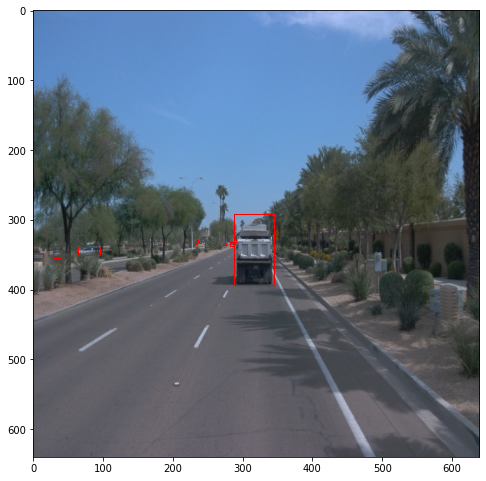

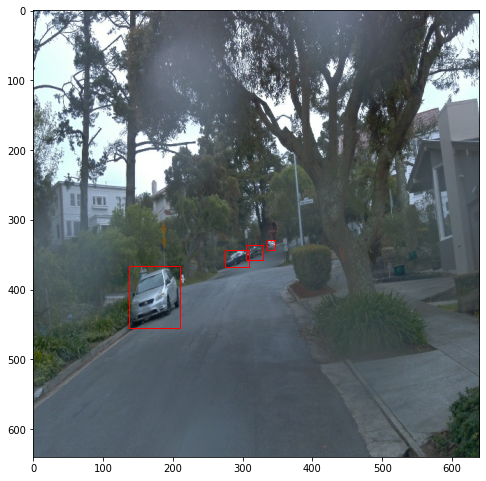

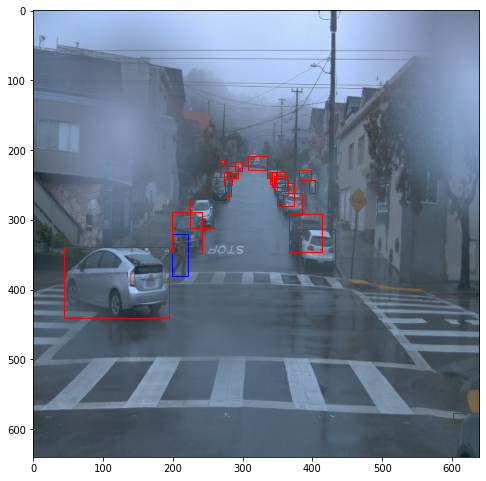

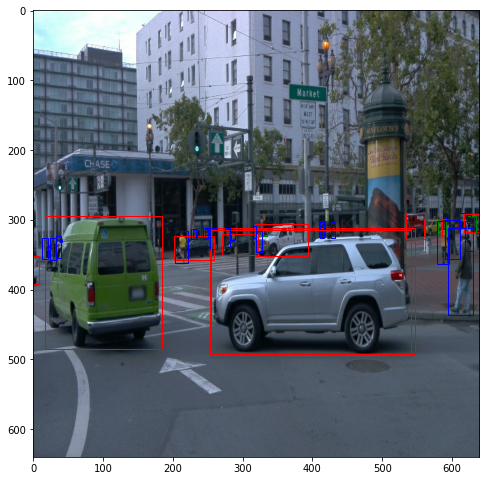

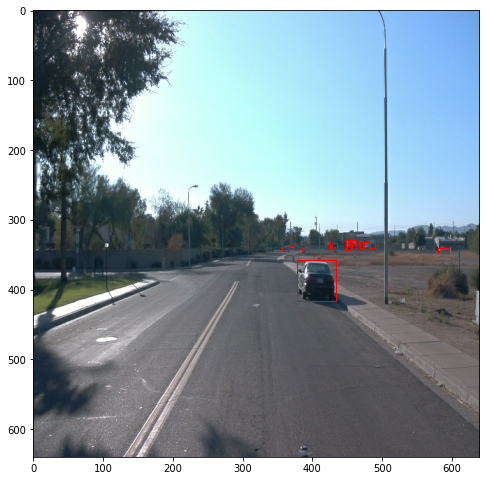

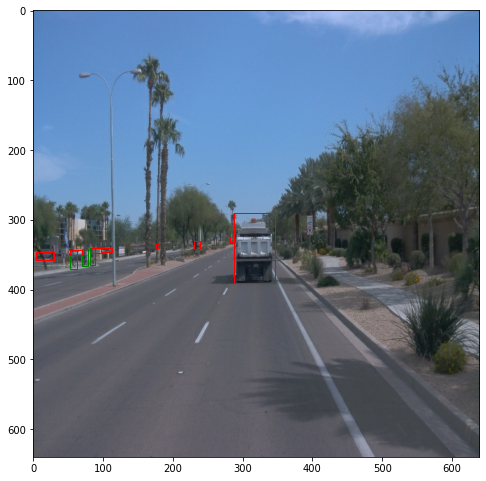

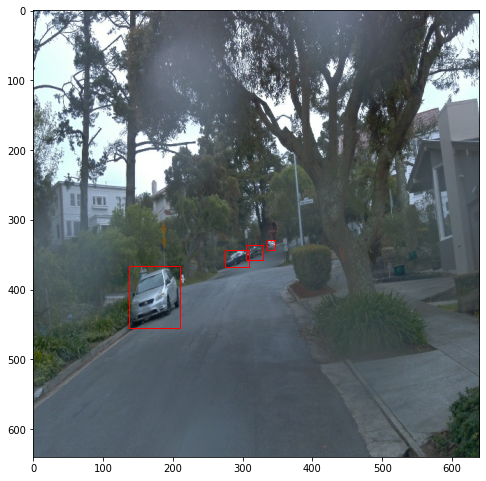

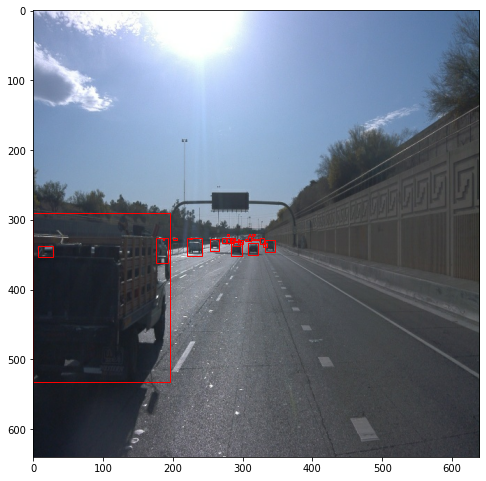

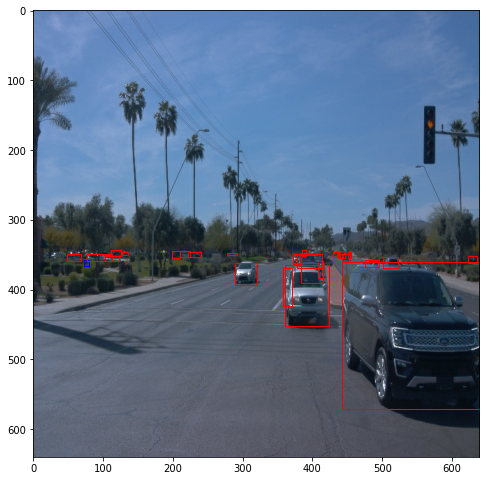

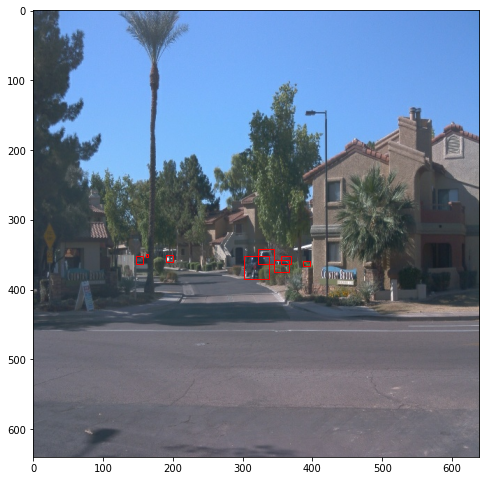

In [5]:
# Display 10 random images in dataset
for data in dataset.take(10):
    display_images(data)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### Object distribution in resized images (10x10)

In [6]:
# Counter of objects for each class
obj_counter = {}

# Counter for each class in each image
class_counter = {1:[], 2:[], 4:[]}

# Object distance
obj_dist = {}  

for sample in tqdm(dataset.take(30000)):
    
    # Class counter initialization
    class_counter[1].append(0)
    class_counter[2].append(0)
    class_counter[4].append(0)
     
    for idx in range(len(sample["groundtruth_classes"])):
        
        gt_classes = sample["groundtruth_classes"].numpy()
        gt_boxes = sample["groundtruth_boxes"].numpy()
        
        # Get number of classes in sample 
        if gt_classes[idx] in obj_counter.keys():
            obj_counter[gt_classes[idx]] += 1
        else:
            obj_counter[gt_classes[idx]] = 1
            
        # Increment counter for current sample 
        class_counter[gt_classes[idx]][-1] += 1
    
        # Get object distance
        ymin, xmin, ymax, xmax = gt_boxes[idx]
        center_x, center_y = int((xmin+xmax)*10/2), int((ymin+ymax)*10/2)
        if gt_classes[idx] not in obj_dist.keys():
            obj_dist[gt_classes[idx]] = np.zeros((10,10,2))

        # Increment counter for distances    
        obj_dist[gt_classes[idx]][center_y, center_x,0] += 1
        
        # Calculate distance (Area) of object
        obj_dist[gt_classes[idx]][int(ymin*10):int(ymax*10)+1, int(xmin*10):int(xmax*10)+1,1] += 1

30000it [01:26, 348.02it/s]


#### Visualization of counted objects

{1: 518722, 2: 145931, 4: 3748}


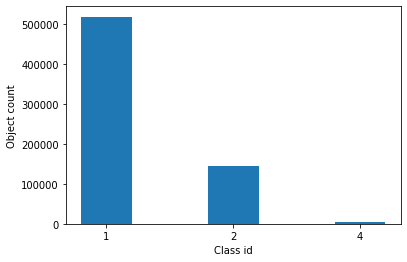

In [7]:
print(obj_counter)
fig = plt.figure()
classes = [str(x) for x in obj_counter.keys()]
plt.bar(classes, obj_counter.values(), width=0.4)
plt.xlabel("Class id")
plt.ylabel("Object count")
plt.show()

####  Visualization of object distribution

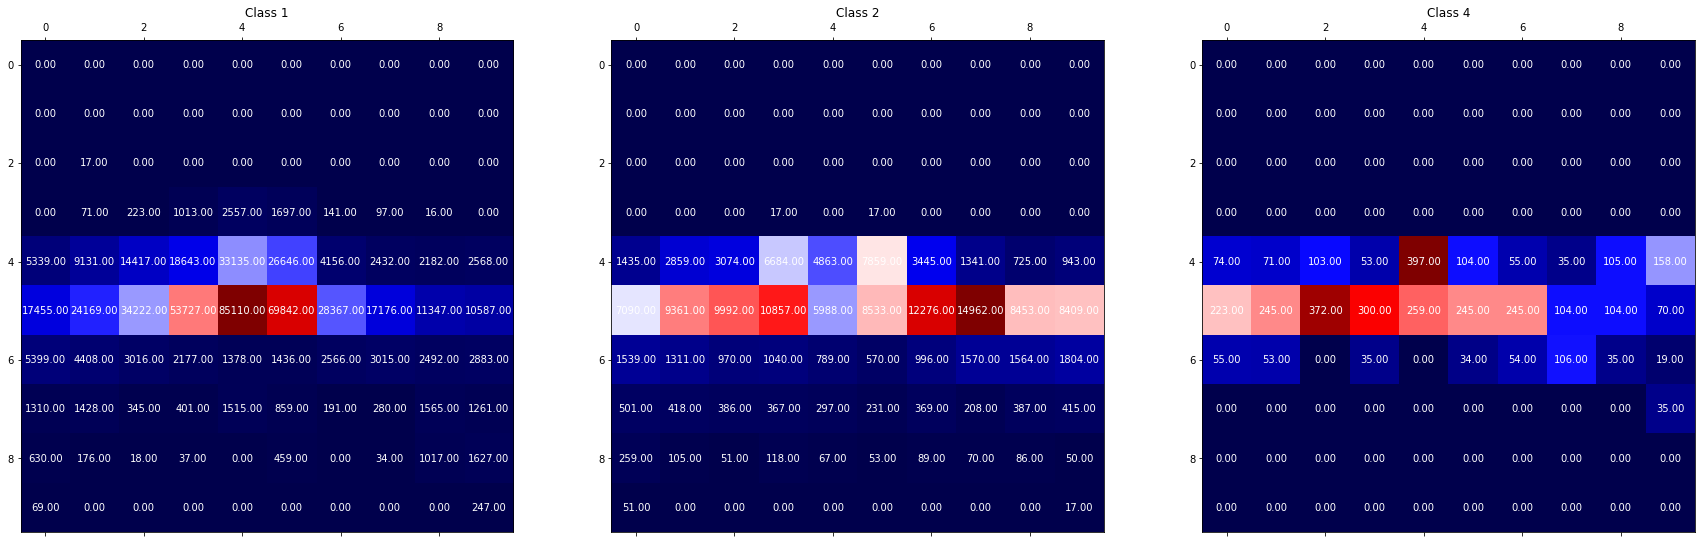

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30,30))

classes = obj_counter.keys()
for ci in range(len(obj_counter.keys())):
    class_ = list(obj_counter.keys())[ci]
    ax[ci].matshow(obj_dist[class_][:,:,0], cmap="seismic")

    s = obj_dist[class_][:,:,0].sum()
    for (i,j), value in np.ndenumerate(obj_dist[class_][:,:,0]):
        ax[ci].text(j, i, "{:0.2f}".format(value), ha="center", va="center", color="white")
        
    ax[ci].set_title("Class " + str(class_))

plt.show()

#### Visualization of area distribution in the selected dataset

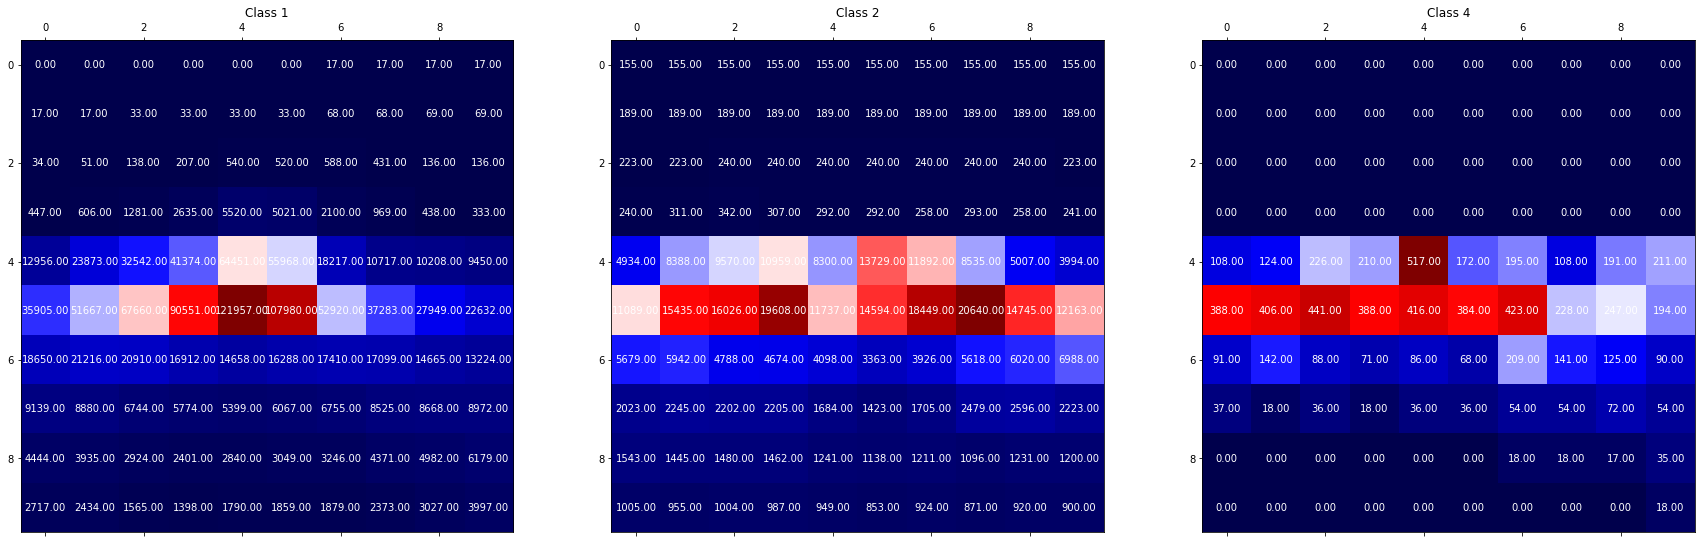

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(30,30))

classes = class_counter.keys()
for ci in range(len(class_counter.keys())):
    class_ = list(class_counter.keys())[ci]
    ax[ci].matshow(obj_dist[class_][:,:,1], cmap="seismic")

    for (i,j), value in np.ndenumerate(obj_dist[class_][:,:,1]):
        ax[ci].text(j, i, "{:0.2f}".format(value), ha="center", va="center", color="white")
        
    ax[ci].set_title("Class " + str(class_))

plt.show()

#### Histigram of each class versus number of samples 

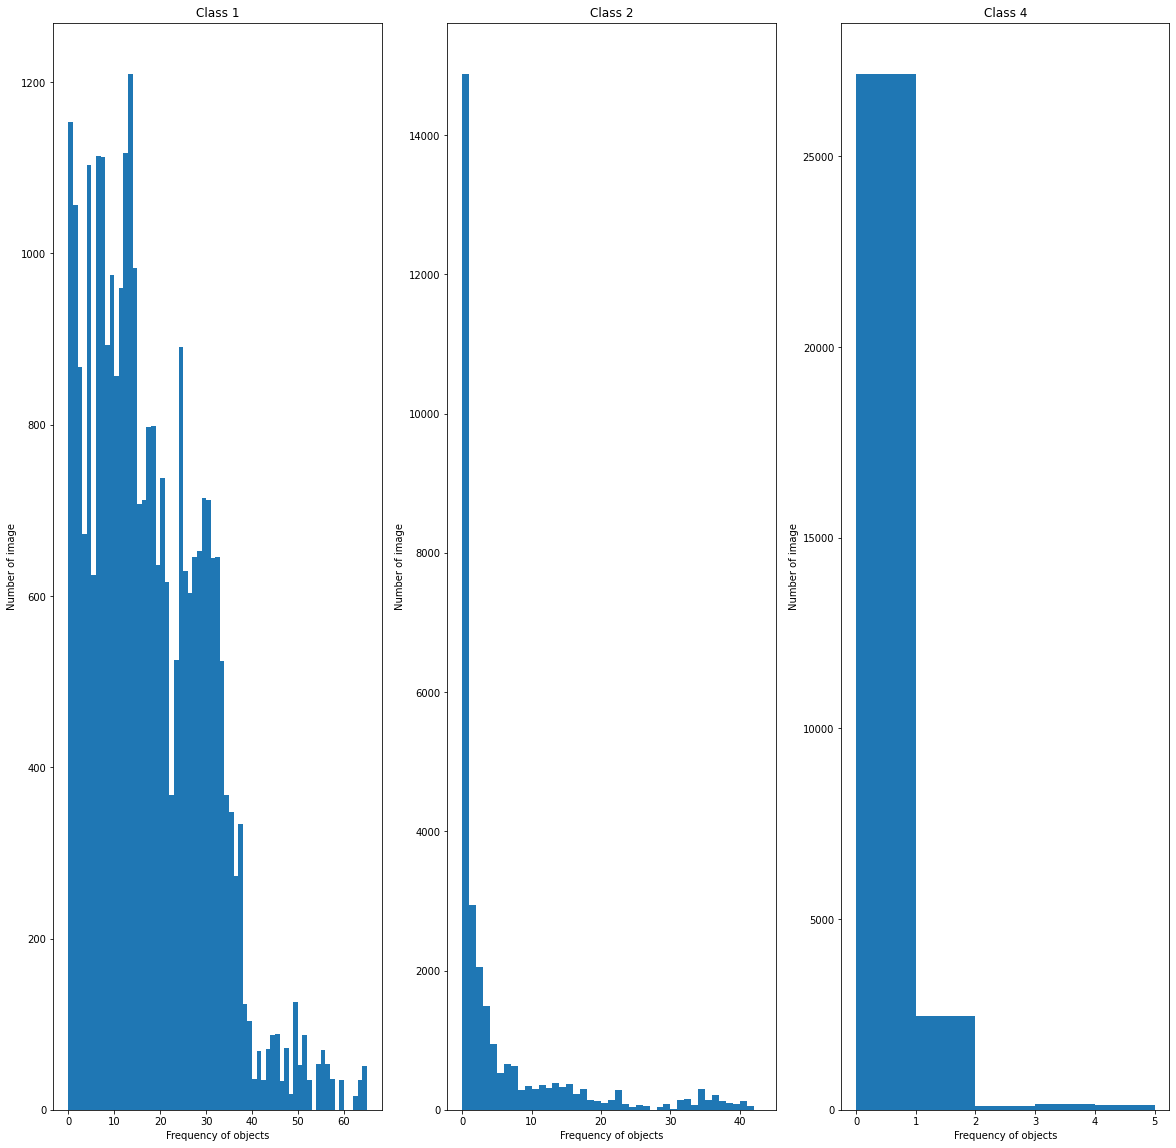

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,20))

classes = list(class_counter.keys())
for ci in range(len(class_counter.keys())):
    class_ = classes[ci]
    ax[ci].hist(class_counter[class_], bins=range(min(class_counter[class_]), max(class_counter[class_])))
    ax[ci].set_title("Class " + str(class_))
    
    ax[ci].set_ylabel("Number of image")
    ax[ci].set_xlabel("Frequency of objects")

plt.show()